# Loading Data and Cleaning

In [1]:
#import basic system functions
import os
import datetime

from datetime import date
from collections import Counter

#import libraries for data wrangling
import pandas as pd
import numpy as np

#import libraries for plotting data
import matplotlib.pyplot as plt


%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pandas.plotting import autocorrelation_plot



#import libraries for time series analysis
#from fbprophet import Prophet
from pylab import rcParams
import statsmodels.api as sm
import holidays


import warnings
warnings.filterwarnings('ignore')


from IPython.display import Image
from datetime import datetime

<span style='font-family:Tahoma'>   </span>

In [2]:
df = pd.read_csv("/Users/brittarover/Capstone/Meteolytics/meteolytix_Artikelgruppen_Umsatz_verschiedeneStandorte.csv")

In [3]:
# Renaming Columnlabels
df['Artikelgruppe']=df['Artikelgruppe'].apply(lambda x: 'Weizenbrot' if x==1 else "Mischbrot" if x==2 else 
                    "Vollkornbrot" if x==3 else "Spezialbrot" if x==4 else "Stangenbrote" if x==5 else "Brötchen"
                                                  if x==6 else "Süsse_Brötchen" if x==7 else
                                              "Herzhafte_Brötchen" if x==8 else "KonditoreiBlech1" if x==9
                                                  else "KonditoreiBlech2" if x==10 else "Stückgebäck" 
                                              if x==11 else
                                              "Blechkuchen" if x==12 else "Weihnachtsartikel" )

In [4]:
df.head()

,Filiale,Datum,Artikelgruppe,Umsatz
0,1,2015-01-07,Weizenbrot,50.092235
1,1,2015-01-27,Weizenbrot,57.002341
2,1,2015-01-30,Weizenbrot,52.920825
3,1,2015-02-02,Weizenbrot,89.343474
4,1,2015-02-05,Weizenbrot,68.717498



### Definitions

- **Filiale** - There are three different filial stores which are analyzed, one direct in the city (filiale=1), one near the water front (filiale=2) and the third in a residential area (filiale=3)
1 = city; 2 = waterfront area; 3 = city disctrict
- **Datum** - date of the sales data. The period 
- **Warengruppe** - main article group
1 = Brot; 2 = Brötchen; 3 = Spezial_Brötchen; 4 = Konditorei; 5 = Kuchen; 6 = Weihnachtsartikel    
- **Artikelgruppe** - article group
1 = Weizenbrot; 2 = Mischbrot; 3 = Vollkornbrot; 4 = Spezialbrot; 5 = Stangenbrote; 6 = Brötchen; 7 = Süße Brötchen; 8 = Herzhafte Brötchen; 9 = KonditoreiBlech1; 10 = KonditoreiBlech2; 11 = Stückgebäck; 12 = Blechkuchen; 13 = Weiohnachtsartikel;     
- **Umsatz** - Sales volumne per day and article group   

### Modify Dataframe with groupby and unstack 

In [5]:
df_new=pd.pivot_table(df, values='Umsatz', index=['Datum','Filiale'],columns=['Artikelgruppe'], 
                        aggfunc=np.sum, fill_value=0).reset_index()

In [6]:
#create empty dataframe with 'complete' datetime index
date_df = pd.DataFrame(index=pd.date_range(start='1/1/2015', end=df.Datum.max()))
df_new_1 = pd.pivot_table(df[df.Filiale == 1], values='Umsatz', index=['Datum'],columns=['Artikelgruppe'], 
                        aggfunc=np.sum, fill_value=0)
#fill missing days due to store closings with 0 
df_new_1=df_new_1.merge(date_df, how='right', left_index= True,right_index=True).fillna(0)
df_new_1.index = df_new_1.index.set_names(['Datum'])
df_new_1=df_new_1.reset_index()

df_new_2 = pd.pivot_table(df[df.Filiale == 2], values='Umsatz', index=['Datum'],columns=['Artikelgruppe'], 
                        aggfunc=np.sum, fill_value=0)
#fill missing days due to store closings with 0 
df_new_2 = df_new_2.merge(date_df, how='right',left_index= True,right_index=True).fillna(0)
df_new_2.index = df_new_2.index.set_names(['Datum'])
df_new_2=df_new_2.reset_index()

df_new_3 = pd.pivot_table(df[df.Filiale == 3], values='Umsatz', index=['Datum'],columns=['Artikelgruppe'], 
                        aggfunc=np.sum, fill_value=0)
#fill missing days due to store closings with 0 
df_new_3 = df_new_3.merge(date_df, how='right',left_index= True,right_index=True).fillna(0)
df_new_3.index = df_new_3.index.set_names(['Datum'])
df_new_3=df_new_3.reset_index()

### Transformation to Datetime

In [7]:
# Transformation to Datetime
dataframe=[df,df_new,df_new_1,df_new_2,df_new_3]

for i in dataframe:
  i['Datum'] = pd.to_datetime(i['Datum'])


### Additional Date columns

In [8]:
for i in dataframe:
   i['Wochentag']=i['Datum'].dt.weekday
   i['Jahr']=i['Datum'].dt.year
   i['Monat']=i['Datum'].dt.month
   i['Wochenende']=i['Wochentag'].apply(lambda x: 'Wochentag' if x in (0,1,2,3,4) else 'Wochenende')
    

### Adding a Gesamt Column

In [9]:
#Adding a Gesamt column to all the new dataframes which contains the total sales
dataframe=[df_new,df_new_1,df_new_2,df_new_3]

for i in dataframe:
    i['Gesamt']=i['Vollkornbrot']+i['Mischbrot']+i['Stangenbrote']+i['Weizenbrot']+i['Spezialbrot']+i['Brötchen']
    +i['Süsse_Brötchen']+i['Herzhafte_Brötchen']+i['KonditoreiBlech1']+i['KonditoreiBlech2']+i['Blechkuchen']
    +i['Weihnachtsartikel']+i['Stückgebäck']

In [10]:
df_new_index = df_new.set_index('Datum')


### Definition of KonditoreiBlech as Sum

In [11]:
#KonditoreiBlech1 is only sold until 2019, so I build the sum of both caketypes
for i in dataframe:
  i['KonditoreiBlech1']=i['KonditoreiBlech1']+i['KonditoreiBlech2']
  i.rename(columns={'KonditoreiBlech1':'KonditoreiBlech'}, inplace=True)
  i.drop('KonditoreiBlech2',axis='columns', inplace=True)

# Boxplots

## Filiale 1

In [ ]:
#plot boxplots for Total in first store
sns.set(rc={'figure.figsize':(16,7.5)})
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

sns.boxplot(data=df_new_1,x='Jahr',y='Gesamt',ax=ax1).set_title(f'Sales per Year for Filiale 1')
sns.boxplot(data=df_new_1,x='Monat',y='Gesamt',ax=ax2).set_title(f'Sales per Month for Filiale 1')
sns.boxplot(data=df_new_1,x='Wochentag',y='Gesamt',ax=ax3).set_title(f'Sales per Weekday for Filiale 1')             

### Brötchen

In [ ]:
#plot boxplots for Brötchen in first store
sns.set(rc={'figure.figsize':(16,7.5)})
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)

sns.boxplot(data=df_new_1,x='Jahr',y='Brötchen',ax=ax1).set_title(f'Sales per Year and articlegroup Brötchen')
sns.boxplot(data=df_new_1,x='Monat',y='Brötchen',ax=ax2).set_title(f'Sales per Month and articlegroup Brötchen')                  
sns.boxplot(data=df_new_1,x='Wochentag',y='Brötchen',ax=ax3).set_title(f'Sales per Weekday and articlegroup Brötchen')


### Süße Brötchen

In [ ]:
#plot boxplots for each article in first store
sns.set(rc={'figure.figsize':(16,7.5)})
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)

sns.boxplot(data=df_new_3,x='Jahr',y='Süsse_Brötchen',ax=ax1).set_title(f'Sales per Year and articlegroup Süße Brötchen')
sns.boxplot(data=df_new_1,x='Monat',y='Süsse_Brötchen',ax=ax2).set_title(f'Sales per Month and articlegroup Süße Brötchen')
sns.boxplot(data=df_new_1,x='Wochentag',y='Süsse_Brötchen',ax=ax3).set_title(f'Sales per Weekday and articlegroup Süße Brötchen')                                                                

### Herzhafte Brötchen

In [ ]:
#plot boxplots for Herzhafte Brötchen in first store
sns.set(rc={'figure.figsize':(16,7.5)})
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)

sns.boxplot(data=df_new_1,x='Jahr',y='Herzhafte_Brötchen',ax=ax1).set_title(f'Sales per Year and articlegroup Herzhafte Brötchen')
sns.boxplot(data=df_new_1,x='Monat',y='Herzhafte_Brötchen',ax=ax2).set_title(f'Sales per Month and articlegroup Herzhafte Brötchen')
sns.boxplot(data=df_new_1,x='Wochentag',y='Herzhafte_Brötchen',ax=ax3).set_title(f'Sales per Weekday and articlegroup Herzhafte Brötchen')

### Blechkuchen

In [ ]:
#plot boxplots for Blechkuchen in first store
sns.set(rc={'figure.figsize':(16,7.5)})
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
name='Blechkuchen'
sns.boxplot(data=df_new_1,x='Jahr',y=name,ax=ax1).set_title(f'Sales per Year and articlegroup {name}')
sns.boxplot(data=df_new_1,x='Monat',y=name,ax=ax2).set_title(f'Sales per Month and articlegroup {name}')
sns.boxplot(data=df_new_1,x='Wochentag',y=name,ax=ax3).set_title(f'Sales per Weekday and articlegroup {name}')

### KonditoreiBlech

In [ ]:
#plot boxplots for KonditoreiBlech in first store
sns.set(rc={'figure.figsize':(16,7.5)})
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)

name='KonditoreiBlech'
sns.boxplot(data=df_new_1,x='Jahr',y=name,ax=ax1).set_title(f'Sales per Year and articlegroup {name}')
sns.boxplot(data=df_new_1,x='Monat',y=name,ax=ax2).set_title(f'Sales per Month and articlegroup {name}')
sns.boxplot(data=df_new_1,x='Wochentag',y=name,ax=ax3).set_title(f'Sales per Weekday and articlegroup {name}')

### Stückgebäck

In [ ]:
#plot boxplots for Stückgebäck in first store
sns.set(rc={'figure.figsize':(16,7.5)})
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
name='Stückgebäck'
sns.boxplot(data=df_new_1,x='Jahr',y=name,ax=ax1).set_title(f'Sales per Year and articlegroup {name}')
sns.boxplot(data=df_new_1,x='Monat',y=name,ax=ax2).set_title(f'Sales per Month and articlegroup {name}')
sns.boxplot(data=df_new_1,x='Wochentag',y=name,ax=ax3).set_title(f'Sales per Weekday and articlegroup {name}')

### Stangenbrote

In [ ]:
#plot boxplots for Stangenbrote in first store
sns.set(rc={'figure.figsize':(16,7.5)})
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
name='Stangenbrote'

sns.boxplot(data=df_new_1,x='Jahr',y=name,ax=ax1).set_title(f'Sales per Year and articlegroup {name}')
sns.boxplot(data=df_new_1,x='Monat',y=name,ax=ax2).set_title(f'Sales per Month and articlegroup {name}')                  
sns.boxplot(data=df_new_1,x='Wochentag',y=name,ax=ax3).set_title(f'Sales per Weekday and articlegroup {name}')

### Weizenbrot

In [ ]:
#plot boxplots for Weizenbrot in first store
sns.set(rc={'figure.figsize':(16,7.5)})
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
name='Weizenbrot'
sns.boxplot(data=df_new_1,x='Jahr',y=name,ax=ax1).set_title(f'Sales per Year and articlegroup {name}')
sns.boxplot(data=df_new_1,x='Monat',y=name,ax=ax2).set_title(f'Sales per Month and articlegroup {name}')
sns.boxplot(data=df_new_1,x='Wochentag',y=name,ax=ax3).set_title(f'Sales per Weekday and articlegroup {name}')

### Mischbrot

In [ ]:
#plot boxplots for Mischbrot in first store
sns.set(rc={'figure.figsize':(16,7.5)})
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
name='Mischbrot'
sns.boxplot(data=df_new_1,x='Jahr',y=name,ax=ax1).set_title(f'Sales per Year and articlegroup {name}')
sns.boxplot(data=df_new_1,x='Monat',y=name,ax=ax2).set_title(f'Sales per Month and articlegroup {name}')                  
sns.boxplot(data=df_new_1,x='Wochentag',y=name,ax=ax3).set_title(f'Sales per Weekday and articlegroup {name}')

### Vollkornbrot

In [ ]:
#plot boxplots for Volkornbrot in first store
sns.set(rc={'figure.figsize':(16,7.5)})
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
name='Vollkornbrot'
sns.boxplot(data=df_new_1,x='Jahr',y=name,ax=ax1).set_title(f'Sales per Year and articlegroup {name}')
sns.boxplot(data=df_new_1,x='Monat',y=name,ax=ax2).set_title(f'Sales per Month and articlegroup {name}')
sns.boxplot(data=df_new_1,x='Wochentag',y=name,ax=ax3).set_title(f'Sales per Weekday and articlegroup {name}')

### Spezialbrot

In [ ]:
#plot boxplots for Spezialbrot in first store
sns.set(rc={'figure.figsize':(16,7.5)})
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
name='Spezialbrot'
sns.boxplot(data=df_new_1,x='Jahr',y=name,ax=ax1).set_title(f'Sales per Year and articlegroup {name}')
sns.boxplot(data=df_new_1,x='Monat',y=name,ax=ax2).set_title(f'Sales per Month and articlegroup {name}')
sns.boxplot(data=df_new_1,x='Wochentag',y=name,ax=ax3).set_title(f'Sales per Weekday and articlegroup {name}')

### Weihnachtsartikel

## Filiale 2

In [ ]:
#plot boxplots for Total in second store
sns.set(rc={'figure.figsize':(16,7.5)})
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

sns.boxplot(data=df_new_2,x='Jahr',y='Gesamt',ax=ax1).set_title(f'Sales per Year for Filiale 2')
sns.boxplot(data=df_new_2,x='Monat',y='Gesamt',ax=ax2).set_title(f'Sales per Month for Filiale 2')
sns.boxplot(data=df_new_2,x='Wochentag',y='Gesamt',ax=ax3).set_title(f'Sales per Weekday for Filiale 2')             

### Brötchen

In [ ]:
#plot boxplots for Brötchen in second store
sns.set(rc={'figure.figsize':(16,7.5)})
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)

sns.boxplot(data=df_new_2,x='Jahr',y='Brötchen',ax=ax1).set_title(f'Sales per Jahr and articlegroup Brötchen')
sns.boxplot(data=df_new_2,x='Monat',y='Brötchen',ax=ax2).set_title(f'Sales per Month and articlegroup Brötchen')
sns.boxplot(data=df_new_2,x='Wochentag',y='Brötchen',ax=ax3).set_title(f'Sales per Weekday and articlegroup Brötchen')                                                                    

### Süße Brötchen

In [ ]:
#plot boxplots for each article in second store
sns.set(rc={'figure.figsize':(16,7.5)})
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)

sns.boxplot(data=df_new_2,x='Jahr',y='Süsse_Brötchen',ax=ax1).set_title(f'Sales per Jahr and articlegroup Süße Brötchen')
sns.boxplot(data=df_new_2,x='Monat',y='Süsse_Brötchen',ax=ax2).set_title(f'Sales per Month and articlegroup Süße Brötchen')
sns.boxplot(data=df_new_2,x='Wochentag',y='Süsse_Brötchen',ax=ax3).set_title(f'Sales per Weekday and articlegroup Süße Brötchen')                                                                

### Herzhafte Brötchen

In [ ]:
#plot boxplots for Herzhafte Brötchen in second store
sns.set(rc={'figure.figsize':(16,7.5)})

fig, (ax1, ax2,ax3) = plt.subplots(1, 3)

sns.boxplot(data=df_new_2,x='Jahr',y='Herzhafte_Brötchen',ax=ax1).set_title(f'Sales per Year and articlegroup Herzhafte Brötchen')
sns.boxplot(data=df_new_2,x='Monat',y='Herzhafte_Brötchen',ax=ax2).set_title(f'Sales per Month and articlegroup Herzhafte Brötchen')
sns.boxplot(data=df_new_2,x='Wochentag',y='Herzhafte_Brötchen',ax=ax3).set_title(f'Sales per Weekday and articlegroup Herzhafte Brötchen')

### Blechkuchen

In [ ]:
#plot boxplots for Blechkuchen in second store
sns.set(rc={'figure.figsize':(16,7.5)})
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
name='Blechkuchen'
sns.boxplot(data=df_new_2,x='Jahr',y=name,ax=ax1).set_title(f'Sales per Year and articlegroup {name}')
sns.boxplot(data=df_new_2,x='Monat',y=name,ax=ax2).set_title(f'Sales per Month and articlegroup {name}')
sns.boxplot(data=df_new_2,x='Wochentag',y=name,ax=ax3).set_title(f'Sales per Weekday and articlegroup {name}')

### KonditoreiBlech

In [ ]:
#plot boxplots for KonditoreiBlech in second store
sns.set(rc={'figure.figsize':(16,7.5)})
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
name='KonditoreiBlech'
sns.boxplot(data=df_new_2,x='Jahr',y=name,ax=ax1).set_title(f'Sales per Month and articlegroup {name}')
sns.boxplot(data=df_new_2,x='Monat',y=name,ax=ax2).set_title(f'Sales per Month and articlegroup {name}')
sns.boxplot(data=df_new_2,x='Wochentag',y=name,ax=ax3).set_title(f'Sales per Weekday and articlegroup {name}')

### Stückgebäck

In [ ]:
#plot boxplots for Stückgebäck in second store
sns.set(rc={'figure.figsize':(16,7.5)})
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
name='Stückgebäck'
sns.boxplot(data=df_new_2,x='Jahr',y=name,ax=ax1).set_title(f'Sales per Year and articlegroup {name}')
sns.boxplot(data=df_new_2,x='Monat',y=name,ax=ax2).set_title(f'Sales per Month and articlegroup {name}')
sns.boxplot(data=df_new_2,x='Wochentag',y=name,ax=ax3).set_title(f'Sales per Weekday and articlegroup {name}')

### Stangenbrote

In [ ]:
#plot boxplots for Stangenbrote in second store
sns.set(rc={'figure.figsize':(16,7.5)})
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
name='Stangenbrote'
sns.boxplot(data=df_new_2,x='Jahr',y=name,ax=ax1).set_title(f'Sales per Year and articlegroup {name}')
sns.boxplot(data=df_new_2,x='Monat',y=name,ax=ax2).set_title(f'Sales per Month and articlegroup {name}')                  
sns.boxplot(data=df_new_2,x='Wochentag',y=name,ax=ax3).set_title(f'Sales per Weekday and articlegroup {name}')

### Weizenbrot

In [ ]:
#plot boxplots for Weizenbrot in second store
sns.set(rc={'figure.figsize':(16,7.5)})
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
name='Weizenbrot'
sns.boxplot(data=df_new_2,x='Jahr',y=name,ax=ax1).set_title(f'Sales per Year and articlegroup {name}')
sns.boxplot(data=df_new_2,x='Monat',y=name,ax=ax2).set_title(f'Sales per Month and articlegroup {name}')                  
sns.boxplot(data=df_new_2,x='Wochentag',y=name,ax=ax3).set_title(f'Sales per Weekday and articlegroup {name}')

### Mischbrot

In [ ]:
#plot boxplots for Mischbrot in second store
sns.set(rc={'figure.figsize':(16,7.5)})
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
name='Mischbrot'
sns.boxplot(data=df_new_2,x='Jahr',y=name,ax=ax1).set_title(f'Sales per Year and articlegroup {name}')
sns.boxplot(data=df_new_2,x='Monat',y=name,ax=ax2).set_title(f'Sales per Month and articlegroup {name}')
sns.boxplot(data=df_new_2,x='Wochentag',y=name,ax=ax3).set_title(f'Sales per Weekday and articlegroup {name}')

### Vollkornbrot

In [ ]:
#plot boxplots for Volkornbrot in second store
plt.figure(figsize=(10,3))
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
name='Vollkornbrot'
sns.boxplot(data=df_new_2,x='Jahr',y=name,ax=ax1).set_title(f'Sales per Year and articlegroup {name}')
sns.boxplot(data=df_new_2,x='Monat',y=name,ax=ax2).set_title(f'Sales per Month and articlegroup {name}')
sns.boxplot(data=df_new_2,x='Wochentag',y=name,ax=ax3).set_title(f'Sales per Weekday and articlegroup {name}')

### Spezialbrot

In [ ]:
#plot boxplots for Spezialbrot in second store
sns.set(rc={'figure.figsize':(16,7.5)})
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
name='Spezialbrot'
sns.boxplot(data=df_new_2,x='Jahr',y=name,ax=ax1).set_title(f'Sales per Year and articlegroup {name}')
sns.boxplot(data=df_new_2,x='Monat',y=name,ax=ax2).set_title(f'Sales per Month and articlegroup {name}')
sns.boxplot(data=df_new_2,x='Wochentag',y=name,ax=ax3).set_title(f'Sales per Weekday and articlegroup {name}')

### Weihnachtsartikel

## Filiale 3

In [ ]:
#plot boxplots for Total in third store
sns.set(rc={'figure.figsize':(16,7.5)})
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

sns.boxplot(data=df_new_3,x='Jahr',y='Gesamt',ax=ax1).set_title(f'Sales per Year for Filiale 3')
sns.boxplot(data=df_new_3,x='Monat',y='Gesamt',ax=ax2).set_title(f'Sales per Month for Filiale 3')
sns.boxplot(data=df_new_3,x='Wochentag',y='Gesamt',ax=ax3).set_title(f'Sales per Weekday for Filiale 3')             

### Brötchen

In [ ]:
#plot boxplots for Brötchen in third store
sns.set(rc={'figure.figsize':(16,7.5)})
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

sns.boxplot(data=df_new_3,x='Jahr',y='Brötchen',ax=ax1).set_title(f'Sales per Year and articlegroup Brötchen')
sns.boxplot(data=df_new_3,x='Monat',y='Brötchen',ax=ax2).set_title(f'Sales per Month and articlegroup Brötchen')
sns.boxplot(data=df_new_3,x='Wochentag',y='Brötchen',ax=ax3).set_title(f'Sales per Weekday and articlegroup Brötchen')                                                                    

### Süße Brötchen

In [ ]:
#plot boxplots for each article in third store
sns.set(rc={'figure.figsize':(16,7.5)})
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)

sns.boxplot(data=df_new_3,x='Jahr',y='Süsse_Brötchen',ax=ax1).set_title(f'Sales per Year and articlegroup Süße Brötchen')

sns.boxplot(data=df_new_3,x='Monat',y='Süsse_Brötchen',ax=ax2).set_title(f'Sales per Month and articlegroup Süße Brötchen')
                  
sns.boxplot(data=df_new_3,x='Wochentag',y='Süsse_Brötchen',ax=ax3).set_title(f'Sales per Weekday and articlegroup Süße Brötchen')                                                                

### Herzhafte Brötchen

In [ ]:
#plot boxplots for Herzhafte Brötchen in third store
plt.figure(figsize=(10,3))
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)

sns.boxplot(data=df_new_3,x='Jahr',y='Herzhafte_Brötchen',ax=ax1).set_title(f'Sales per Year and articlegroup Herzhafte Brötchen')

sns.boxplot(data=df_new_3,x='Monat',y='Herzhafte_Brötchen',ax=ax2).set_title(f'Sales per Month and articlegroup Herzhafte Brötchen')
                  
sns.boxplot(data=df_new_3,x='Wochentag',y='Herzhafte_Brötchen',ax=ax3).set_title(f'Sales per Weekday and articlegroup Herzhafte Brötchen')

### Blechkuchen

In [ ]:
#plot boxplots for Blechkuchen in third store
sns.set(rc={'figure.figsize':(16,7.5)})
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
name='Blechkuchen'
sns.boxplot(data=df_new_3,x='Jahr',y=name,ax=ax1).set_title(f'Sales per Year and articlegroup {name}')
sns.boxplot(data=df_new_3,x='Monat',y=name,ax=ax2).set_title(f'Sales per Month and articlegroup {name}')
sns.boxplot(data=df_new_3,x='Wochentag',y=name,ax=ax3).set_title(f'Sales per Weekday and articlegroup {name}')

### KonditoreiBlech

In [ ]:
#plot boxplots for KonditoreiBlech in third store
plt.figure(figsize=(10,3))
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
name='KonditoreiBlech'
sns.boxplot(data=df_new_3,x='Jahr',y=name,ax=ax1).set_title(f'Sales per Year and articlegroup {name}')
sns.boxplot(data=df_new_3,x='Monat',y=name,ax=ax2).set_title(f'Sales per Month and articlegroup {name}')
sns.boxplot(data=df_new_3,x='Wochentag',y=name,ax=ax3).set_title(f'Sales per Weekday and articlegroup {name}')

### Stückgebäck

In [ ]:
#plot boxplots for Stückgebäck in third store
plt.figure(figsize=(10,3))
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
name='Stückgebäck'

sns.boxplot(data=df_new_3,x='Jahr',y=name,ax=ax1).set_title(f'Sales per Year and articlegroup {name}')
sns.boxplot(data=df_new_3,x='Monat',y=name,ax=ax2).set_title(f'Sales per Month and articlegroup {name}')
sns.boxplot(data=df_new_3,x='Wochentag',y=name,ax=ax3).set_title(f'Sales per Weekday and articlegroup {name}')

### Stangenbrote

In [ ]:
#plot boxplots for Stangenbrote in third store
plt.figure(figsize=(10,3))
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
name='Stangenbrote'
sns.boxplot(data=df_new_3,x='Jahr',y=name,ax=ax1).set_title(f'Sales per Year and articlegroup {name}')
sns.boxplot(data=df_new_3,x='Monat',y=name,ax=ax2).set_title(f'Sales per Month and articlegroup {name}')
sns.boxplot(data=df_new_3,x='Wochentag',y=name,ax=ax3).set_title(f'Sales per Weekday and articlegroup {name}')

### Weizenbrot

In [ ]:
#plot boxplots for Weizenbrot in third store
plt.figure(figsize=(10,3))
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
name='Weizenbrot'
sns.boxplot(data=df_new_3,x='Jahr',y=name,ax=ax1).set_title(f'Sales per Year and articlegroup {name}')
sns.boxplot(data=df_new_3,x='Monat',y=name,ax=ax2).set_title(f'Sales per Month and articlegroup {name}')
sns.boxplot(data=df_new_3,x='Wochentag',y=name,ax=ax3).set_title(f'Sales per Weekday and articlegroup {name}')

### Mischbrot

In [ ]:
#plot boxplots for Mischbrot in third store
plt.figure(figsize=(10,3))
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
name='Mischbrot'
sns.boxplot(data=df_new_3,x='Jahr',y=name,ax=ax1).set_title(f'Sales per Year and articlegroup {name}')
sns.boxplot(data=df_new_3,x='Monat',y=name,ax=ax2).set_title(f'Sales per Month and articlegroup {name}')
sns.boxplot(data=df_new_3,x='Wochentag',y=name,ax=ax3).set_title(f'Sales per Weekday and articlegroup {name}')

### Vollkornbrot

In [ ]:
#plot boxplots for Volkornbrot in third store
plt.figure(figsize=(10,3))
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
name='Vollkornbrot'
sns.boxplot(data=df_new_3,x='Jahr',y=name,ax=ax1).set_title(f'Sales per Year and articlegroup {name}')
sns.boxplot(data=df_new_3,x='Monat',y=name,ax=ax2).set_title(f'Sales per Month and articlegroup {name}')
sns.boxplot(data=df_new_3,x='Wochentag',y=name,ax=ax3).set_title(f'Sales per Weekday and articlegroup {name}')

### Spezialbrot

In [ ]:
#plot boxplots for Spezialbrot in third store
plt.figure(figsize=(10,3))
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
name='Spezialbrot'
sns.boxplot(data=df_new_3,x='Jahr',y=name,ax=ax1).set_title(f'Sales per Year and articlegroup {name}')
sns.boxplot(data=df_new_3,x='Monat',y=name,ax=ax2).set_title(f'Sales per Month and articlegroup {name}')
sns.boxplot(data=df_new_3,x='Wochentag',y=name,ax=ax3).set_title(f'Sales per Weekday and articlegroup {name}')

### Weihnachtsartikel

# Histogramms

## Filiale 1

In [12]:
df_model_1=df_new_1.iloc[:,1:12]

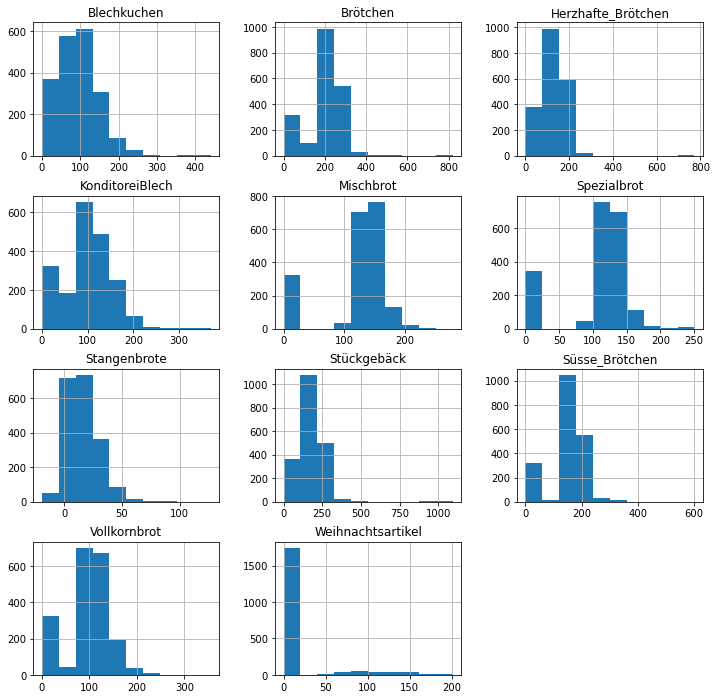

In [13]:
_ = df_model_1.hist(figsize=(12,12))


## Filiale 2

In [14]:
df_model_2=df_new_2.iloc[:,1:12]

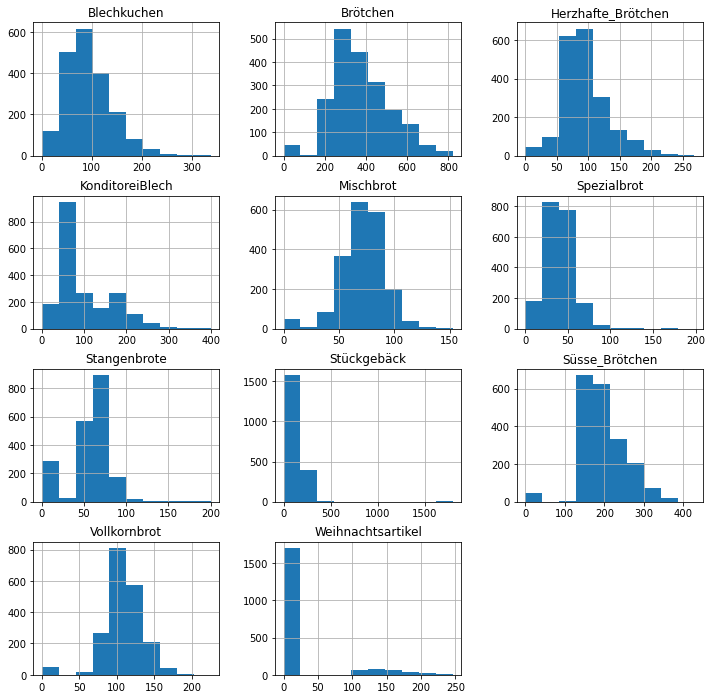

In [15]:
_ = df_model_2.hist(figsize=(12,12))

## Filiale 3

In [16]:
df_model_3=df_new_3.iloc[:,1:12]

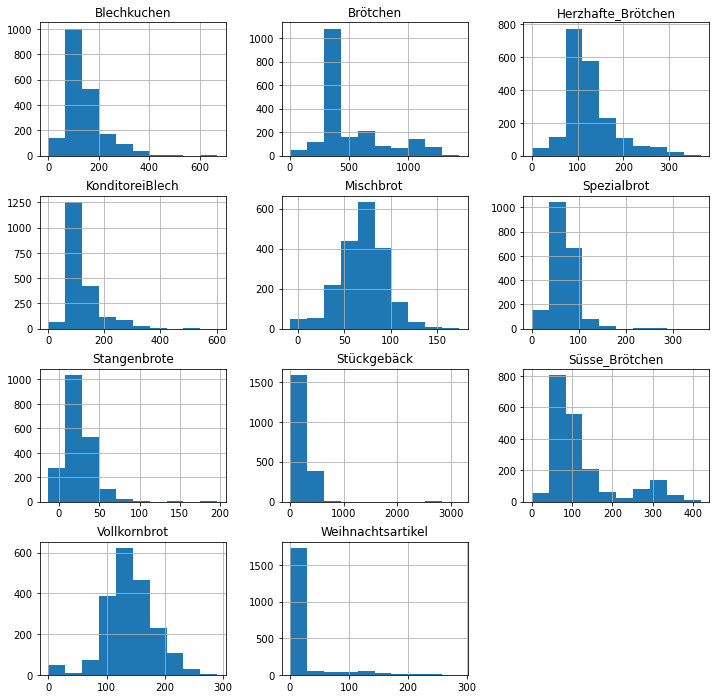

In [17]:
_ = df_model_3.hist(figsize=(12,12))

# Correlations

In [136]:
#First we create a new DataFrame with only numerical features
numerics = ['int64', 'float64']

num_df_2 = df_new_2.select_dtypes(include=numerics)

<function matplotlib.pyplot.show(close=None, block=None)>

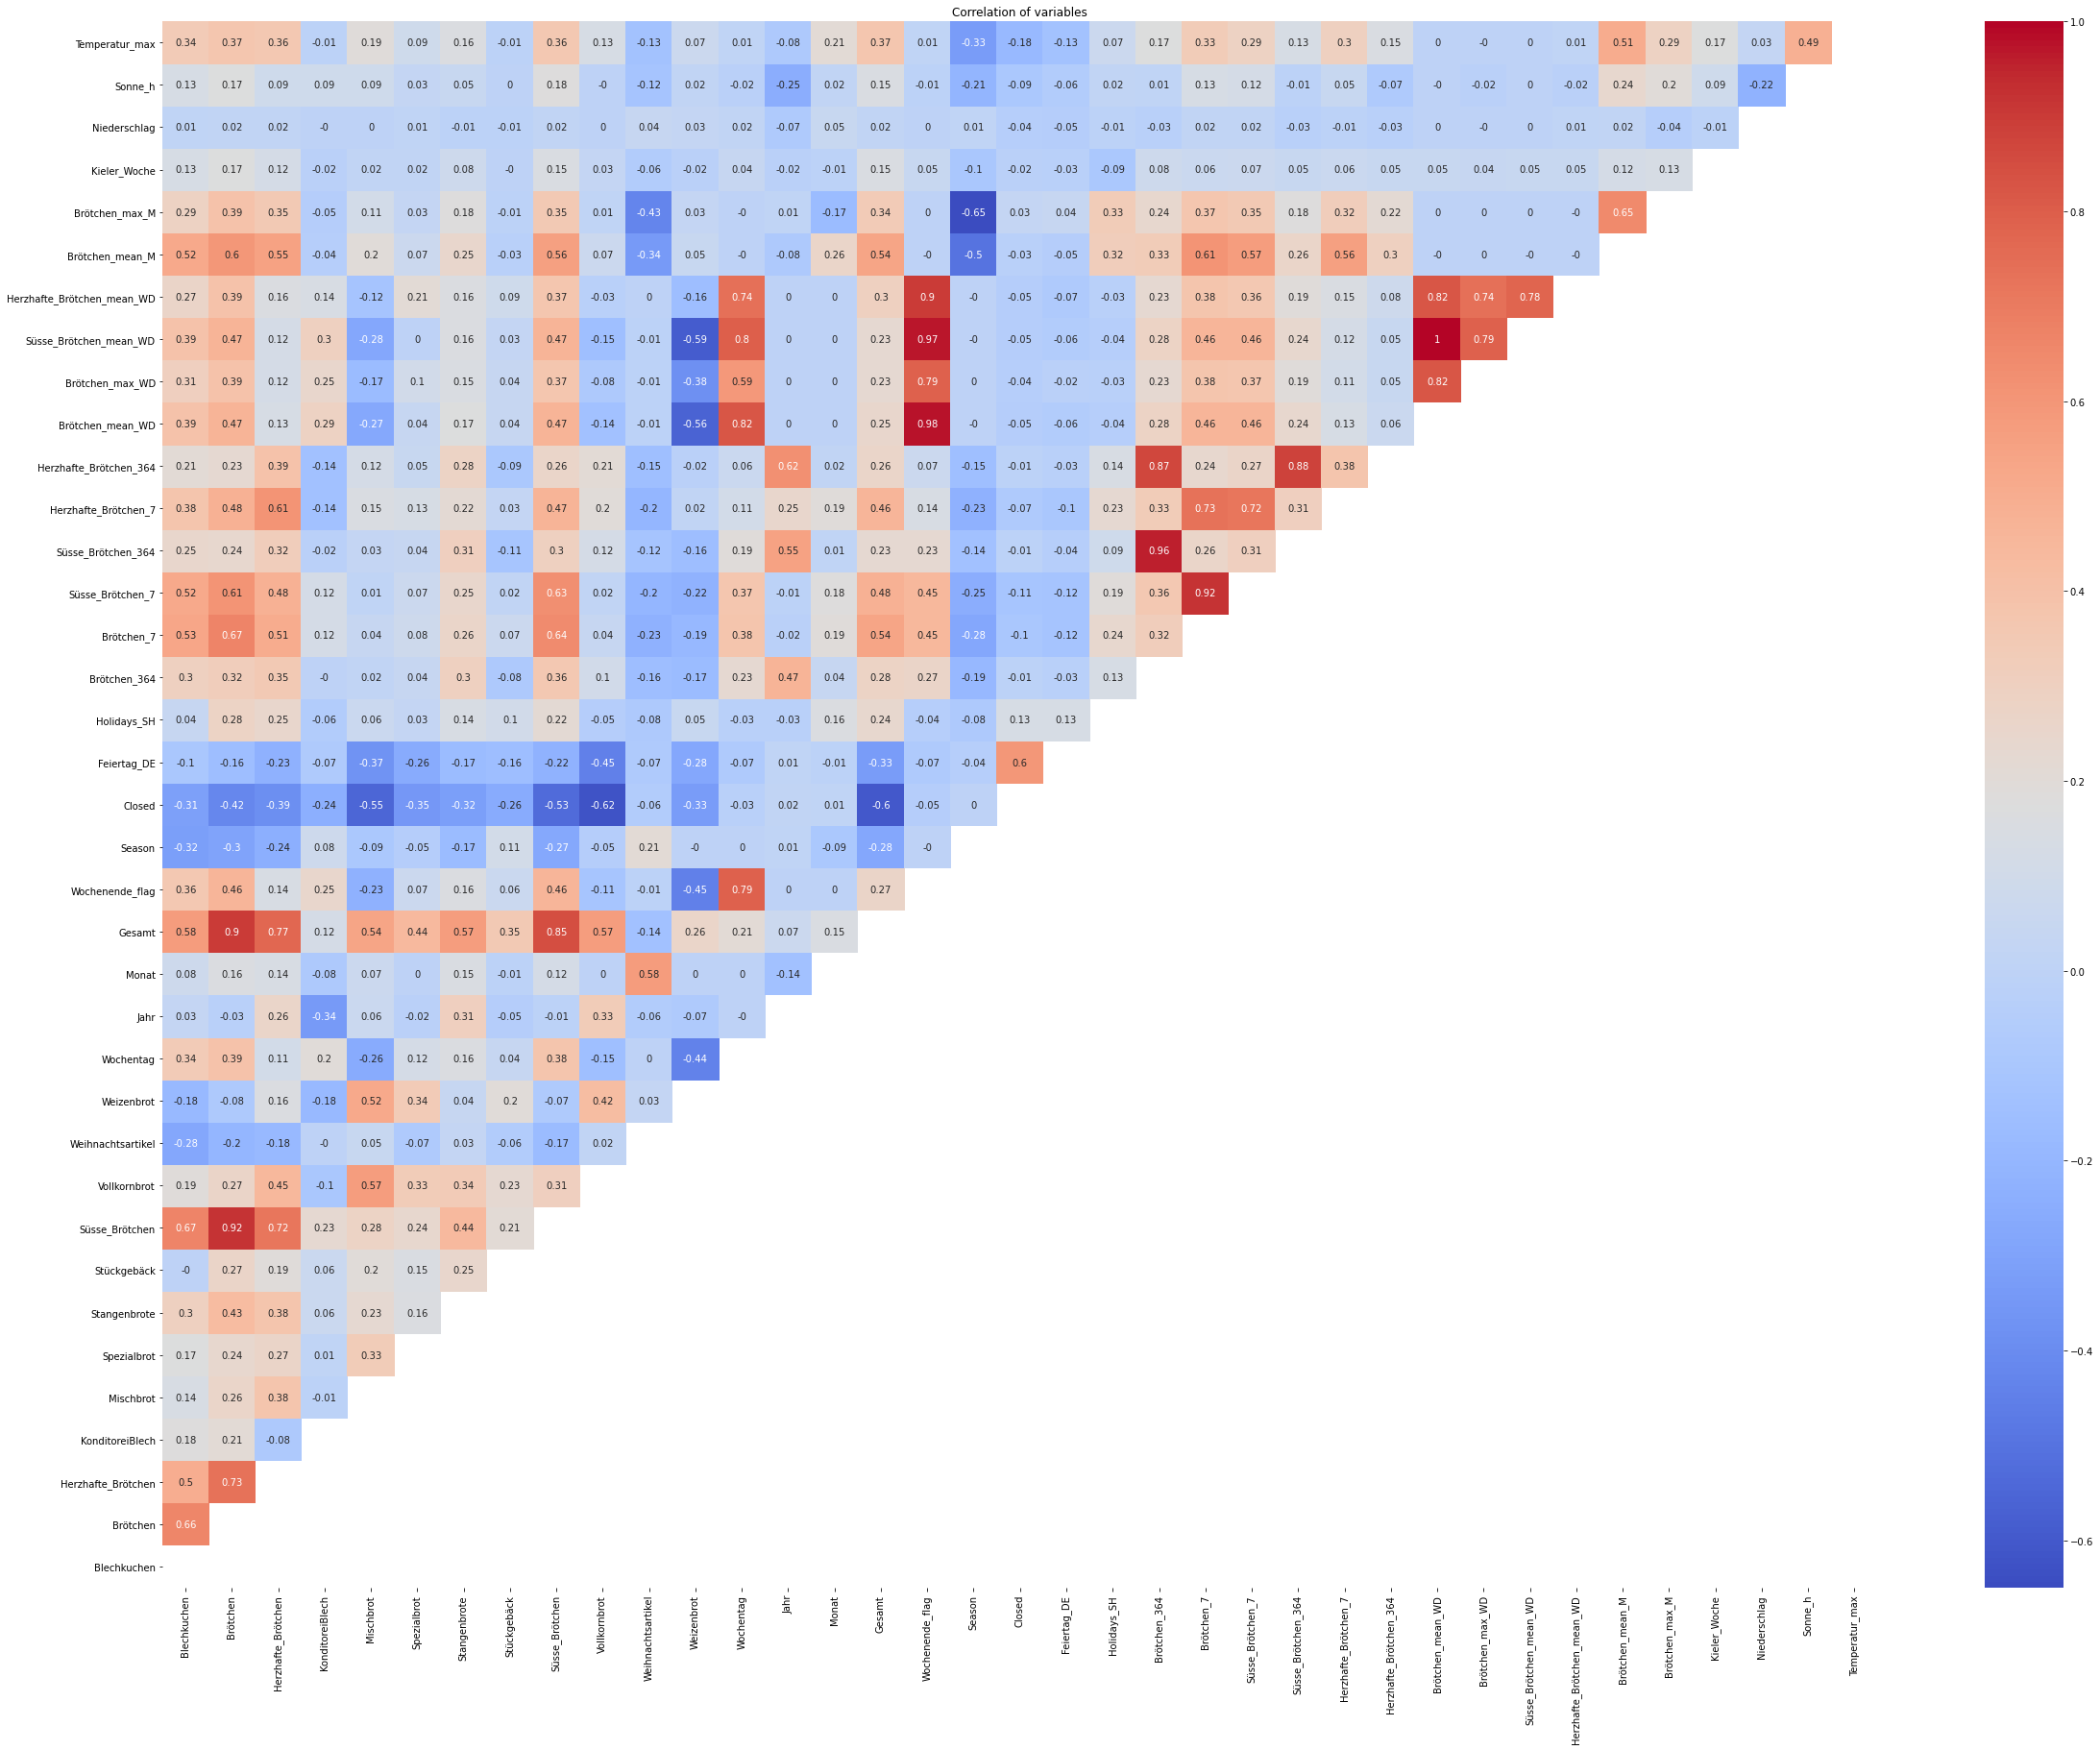

In [137]:
#Korrelationsanalyse
mask = np.triu( num_df_2.corr())
plt.figure(figsize=(40,30))
plt.title('Correlation of variables')
ax=sns.heatmap(num_df_2.corr().round(2),vmax=1.0,annot=True,mask=mask,cmap='coolwarm')
plt.savefig('correlogram_simple.png')
ax.set_ylim((0,37))
plt.show

# Feature Engineering

In [ ]:
#Change of the Wochenende column
df_new_2['Wochenende_flag']=df_new_2['Wochenende'].apply(lambda x: 1 if x=='Wochenende' else 0)
df_new_2['Wochenende_flag']=pd.to_numeric(df_new_2['Wochenende'])

## Season

In [21]:
def season_of_date(date):
    year = str(date.year)
    seasons = {'spring': pd.date_range(start='21/03/'+year, end='20/06/'+year),
               'summer': pd.date_range(start='21/06/'+year, end='22/09/'+year),
               'autumn': pd.date_range(start='23/09/'+year, end='20/12/'+year)}
    if date in seasons['spring']:
        return '1'
    if date in seasons['summer']:
        return '2'
    if date in seasons['autumn']:
        return '3'
    else:
        return '4'

# Assuming df has a date column of type `datetime`
df_new_2['Season'] = df_new_2.Datum.map(season_of_date)

In [34]:
df_new_2['Season']=pd.to_numeric(df_new_2['Season'])

## Closed Flag

In [22]:
df_new_2['Closed']=df_new_2['Gesamt'].apply(lambda x: 1 if x==0 else 0)
df_new_2['Closed']=pd.to_numeric(df_new_2['Closed'])

## Timerelated Values

### Values of the previous Week and Jahr

In [35]:
#Value of the previous Year
df_new_2['Brötchen_364'] = df_new_2.Brötchen.shift(364)
df_new_2['Brötchen_364'].fillna(0)

0         0.000000
1         0.000000
2         0.000000
3         0.000000
4         0.000000
           ...    
1974    564.408017
1975    528.975194
1976    593.424106
1977    517.679428
1978    256.875343
Name: Brötchen_364, Length: 1979, dtype: float64

In [36]:
#Value of the previous Week
df_new_2['Brötchen_7'] = df_new_2.Brötchen.shift(7)
df_new_2['Brötchen_7'].fillna(0)

0         0.000000
1         0.000000
2         0.000000
3         0.000000
4         0.000000
           ...    
1974    604.296365
1975    614.900559
1976    637.206699
1977    641.237676
1978    383.967478
Name: Brötchen_7, Length: 1979, dtype: float64

In [37]:
#For multiple Columns and also Dataframes
var=['Süsse_Brötchen','Herzhafte_Brötchen']
numbers=[7,364]

for i in var:
    for j in numbers:
       df_new_2["%s_%d" % (i,j)]=df_new_2[i].shift(j)
       df_new_2["%s_%d" % (i,j)].fillna(0)

### mean and max-Values for Weekday and Monthly Values

**Conclusions**
- `Mean and Maxvalues have no significant impact to the correlation. I need to do it for Months and Weekdays.`


In [38]:
def Brötchen_mean(x):
    return df_new_2.groupby('Wochentag')['Brötchen'].mean()[x]
def Brötchen_max(x):
    return df_new_2.groupby('Wochentag')['Brötchen'].max()[x]


In [39]:
df_new_2['Brötchen_mean_WD']=df_new_2['Wochentag'].apply(lambda x:  Brötchen_mean(x))
df_new_2['Brötchen_max_WD']=df_new_2['Wochentag'].apply(lambda x:  Brötchen_max(x))


In [40]:
#For multiple Columns and also Dataframes
var=['Süsse_Brötchen','Herzhafte_Brötchen']


for i in var:
    name=i+ "_mean"
    
    def name(x):
        return df_new_2.groupby('Wochentag')['%s' % (i)].mean()[x]

    df_new_2['%s_mean_WD' % (i)]=df_new_2['Wochentag'].apply(lambda x:  name(x))
                                                          

In [41]:
def Brötchen_mean_M(x):
    return df_new_2.groupby('Monat')['Brötchen'].mean()[x]
def Brötchen_max_M(x):
    return df_new_2.groupby('Monat')['Brötchen'].max()[x]


In [42]:
df_new_2['Brötchen_mean_M']=df_new_2['Monat'].apply(lambda x:  Brötchen_mean_M(x))
df_new_2['Brötchen_max_M']=df_new_2['Monat'].apply(lambda x:  Brötchen_max_M(x))


In [ ]:
df_new_1.drop(columns=['date_x'],inplace=True)

## Holidays

### Public Celebrationdays via package holidays

In [23]:
#Definition of Feiertage
de_celebration_days=[]
for date in holidays.Germany(years=2020).items():
    de_celebration_days.append(str(date[0]))
for date in holidays.Germany(years =2019).items():
    de_celebration_days.append(str(date[0]))
for date in holidays.Germany(years=2018).items():
    de_celebration_days.append(str(date[0]))
for date in holidays.Germany(years=2017).items():
    de_celebration_days.append(str(date[0]))
for date in holidays.Germany(years=2016).items():
    de_celebration_days.append(str(date[0]))
for date in holidays.Germany(years=2015).items():
    de_celebration_days.append(str(date[0]))     

In [24]:
#Definition of new column Feiertage_DE
df_new_2['Feiertag_DE']=df_new_2['Datum'].apply(lambda x: 1 if x.strftime(format = "%Y-%m-%d") in de_celebration_days else 0)

In [25]:
holidays_sh = pd.DataFrame({'date':pd.date_range('2019-12-23', '2020-01-06')})
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2020-03-31', '2020-04-17')}))
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2018-12-10', '2019-01-04')}))
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2019-04-04', '2019-04-18')}))
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2019-05-30', '2019-05-30')}))                    
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2019-07-01', '2019-08-08')}))               
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2019-10-05', '2019-10-17')}))
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2017-12-21', '2018-01-06')}))
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2018-03-29', '2018-04-13')}))
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2018-05-11', '2018-05-11')}))                    
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2018-07-09', '2018-08-17')}))               
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2018-10-01', '2018-10-19')}))    
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2016-12-23', '2017-01-06')}))
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2017-04-07', '2017-04-21')}))
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2017-05-26', '2017-05-26')}))                    
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2017-07-24', '2017-09-02')}))               
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2017-10-16', '2017-10-27')}))       
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2015-12-21', '2016-01-06')}))
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2016-03-24', '2016-04-09')}))
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2016-05-16', '2016-05-16')}))                    
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2016-07-25', '2016-09-02')}))               
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2016-10-17', '2016-10-29')}))    
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2014-12-22', '2015-01-06')}))
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2015-04-01', '2015-04-17')}))
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2015-05-11', '2015-05-11')}))                    
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2015-07-20', '2015-08-29')}))               
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2015-10-19', '2015-10-31')}))    


holidays_sh = holidays_sh.sort_values('date') 
holidays_sh['Holidays_SH']=1


In [26]:
df_new_2=pd.merge(df_new_2,holidays_sh,left_on='Datum',right_on='date',how='left').fillna(0)

### Kieler Woche

In [50]:
kieler_woche= pd.DataFrame({'date':pd.date_range('2019-06-22', '2019-06-30')})
kieler_woche = kieler_woche.append(pd.DataFrame({'date':pd.date_range('2018-06-16', '2018-06-24')}))
kieler_woche = kieler_woche.append(pd.DataFrame({'date':pd.date_range('2017-06-17', '2017-06-25')}))
kieler_woche = kieler_woche.append(pd.DataFrame({'date':pd.date_range('2016-06-18', '2016-06-26')}))
kieler_woche = kieler_woche.append(pd.DataFrame({'date':pd.date_range('2015-06-20', '2015-06-28')}))

In [77]:
kieler_woche['Datum']=kieler_woche['date'].apply(lambda x: x.strftime(format = "%Y-%m-%d"))
liste_kw=kieler_woche['Datum'].tolist()

In [75]:
#Definition of new column Feiertage_DE
df_new_2['Kieler_Woche']=df_new_2['Datum'].apply(lambda x: 1 if x.strftime(format = "%Y-%m-%d") in liste_kw else 0)

In [76]:
df_new_2['Kieler_Woche'].value_counts()

0    1934
1      45
Name: Kieler_Woche, dtype: int64

### Further Use

In [ ]:
import holidays

#prov = BW, BY, BE, BB, HB, HH, HE, MV, NI, NW, RP, SL, SN, ST, SH, TH

holidays_SH = holidays.CountryHoliday('DE', prov='SH', state=None )


In [ ]:
def holidays_sh(date):
    date = date.strftime(format = "%d/%m/%Y")
    holidays_2020 = {'Weihnachten': pd.date_range(start='23/12/2019', end='06/01/2020'),
                     'Ostern': pd.date_range(start='31/03/2020', end='17/04/2020')}
    if date in holidays_2020['Weihnachten']:
        return 'Hallo'
    if date in holidays_2020['Ostern']:
        return '2'
    else:
        return '0'

In [ ]:
    holidays_2019 = {'Weihnachten': pd.date_range(start='20/12/2018', end='04/01/2019'),
                     'Ostern': pd.date_range(start='04/04/2019', end='18/04/2019'),
               'Pfingsten':pd.date_range(start='30/05/2019', end='30/05/2019'),
               'Sommer': pd.date_range(start='01/07/2019', end='08/08/2019'),
               'Herbst': pd.date_range(start='05/10/2019', end='17/10/2019')}
    holidays_2018 = {'Weihnachten': pd.date_range(start='21/12/2017', end='06/01/2018'),
               'Ostern': pd.date_range(start='29/03/2018', end='13/04/2018'),
               'Pfingsten':pd.date_range(start='11/05/2018', end='11/05/2018'),
               'Sommer': pd.date_range(start='09/07/2018', end='17/08/2018'),
               'Herbst': pd.date_range(start='01/10/2018', end='19/10/2018')}
    holidays_2017 = {'Weihnachten': pd.date_range(start='23/12/2016', end='06/01/2017'),
               'Ostern': pd.date_range(start='07/04/2017', end='21/04/2017'),
               'Pfingsten':pd.date_range(start='26/05/2017', end='26/05/2017'),
               'Sommer': pd.date_range(start='24/07/2017', end='02/09/2017'),
               'Herbst': pd.date_range(start='16/10/2017', end='27/10/2017')}
    holidays_2016 = {'Weihnachten': pd.date_range(start='21/12/2015', end='06/01/2016'),
               'Ostern': pd.date_range(start='24/03/2016', end='09/04/2016'),
               'Pfingsten':pd.date_range(start='16/05/2016', end='16/05/2016'),
               'Sommer': pd.date_range(start='25/07/2016', end='17/08/2016'),
               'Herbst': pd.date_range(start='17/10/2016', end='29/10/2016')}
    holidays_2015 = {'Weihnachten': pd.date_range(start='22/12/2014', end='06/01/2015'),
               'Ostern': pd.date_range(start='01/04/2015', end='17/04/2015'),
               'Pfingsten':pd.date_range(start='11/05/2015', end='11/05/2015'),
               'Sommer': pd.date_range(start='20/07/2015', end='29/08/2015'),
               'Herbst': pd.date_range(start='19/10/2015', end='31/10/2015')}
    if date in holidays_2020['Weihnachten']:
    #or  holidays_2019['Weihnachten'] or  holidays_2018['Weihnachten'] or holidays_2017['Weihnachten'] or  holidays_2016['Weihnachten'] or  holidays_2015['Weihnachten']:
        return 1
    if date in holidays_2019['Weihnachten']:
        return 1
    if date in holidays_2020['Ostern']:
                #or holidays_2019['Ostern'] or holidays_2018['Ostern'] or holidays_2017['Ostern'] or  holidays_2016['Ostern'] or holidays_2015['Ostern']):
        return 2
    if date in holidays_2019['Ostern']:
                #or holidays_2019['Ostern'] or holidays_2018['Ostern'] or holidays_2017['Ostern'] or  holidays_2016['Ostern'] or holidays_2015['Ostern']):
        return 2            
    if date in holidays_2019['Pfingsten']:
                #or holidays_2018['Pfingsten'] or holidays_2017['Pfingsten'] or holidays_2016['Pfingsten'] or holidays_2015['Pfingsten']:
        return 3
    if date in holidays_2019['Sommer']:
            #or holidays_2018['Sommer'] or holidays_2017['Sommer'] or holidays_2016['Sommer'] or holidays_2015['Sommer']:
        return 4
    if date in  holidays_2019['Herbst']:
            #or holidays_2018['Herbst'] or holidays_2017['Herbst'] or holidays_2016['Herbst'] or holidays_2015['Herbst']:
        return 5
    else:
        return 0

# Assuming df has a date column of type `datetime`
df_new_2['Holidays_SH'] = df_new_2.Datum.map(holidays_sh)    

## Verkaufsfreie Sonntage

## Other dates of importance like Kieler Woche

## Wheather data from dwd/weste

In [108]:
df_wetter = pd.read_csv("Wetterdaten_Kiel_gesamt.csv",delimiter=';')

In [114]:
df_wetter.head()
#df_wetter.drop(columns=['Unnamed: 4'],inplace=True)

,Datum,Niederschlag,Sonne_h,Temperatur_max
0,01.01.2015,8,0,"6,2"
1,02.01.2015,"2,2","0,7","9,5"
2,03.01.2015,"4,2",0,"5,9"
3,04.01.2015,0,"4,7","5,8"
4,05.01.2015,"0,2",0,"6,1"


In [118]:
df_wetter.Datum=pd.to_datetime(df_wetter['Datum'])

In [141]:
df_new_1=pd.merge(df_new_1,df_wetter,left_on='Datum',right_on='Datum',how='left').fillna(0)

In [131]:
df_new_2.Niederschlag=df_new_2.Niederschlag.apply(lambda x: str(x).replace(",", "."))
df_new_2.Sonne_h=df_new_2.Sonne_h.apply(lambda x: str(x).replace(",", "."))
df_new_2.Temperatur_max=df_new_2.Temperatur_max.apply(lambda x: str(x).replace(",", "."))

In [132]:
df_new_2['Niederschlag']=pd.to_numeric(df_new_2['Niederschlag'])

In [133]:
df_new_2['Sonne_h']=pd.to_numeric(df_new_2['Sonne_h'])
df_new_2['Temperatur_max']=pd.to_numeric(df_new_2['Temperatur_max'])

In [139]:
df_new_2.shape

(1980, 40)

In [143]:
df_new_3.shape

(1979, 18)